# 📈 Apple Stock (2020-2025): Analysis & Prediction (ARIMA, LSTM)

Welcome! This notebook analyzes Apple stock data from 2020 to 2025.  
**Objectives:**
- Clean and explore the data
- Visualize trends and patterns
- Build and compare forecasting models (ARIMA, LSTM)
- Summarize key insights


## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')

## Load & Inspect Data
**Steps**
- Load apple stock data from csv
- convert date column to datetime
- sort data by date

In [2]:
df = pd.read_csv(r"E:\DataScience\Apple Stock (2020-2025)\apple_5yr_one.csv", skiprows=1)
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)
df.head()

,Date,Close,High,Low,Open,Volume
0,2020-06-04,78.329315,79.131269,77.955067,78.832363,87560400
1,2020-06-05,80.560219,80.620973,78.550469,78.579630,137250400
2,2020-06-08,81.036537,81.070563,79.544415,80.256454,95654400
3,2020-06-09,83.595505,83.989192,80.684163,80.715756,147712400
4,2020-06-10,85.746208,86.215230,84.105842,84.545702,166651600


## Quick Data Glimpse 


In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1255 non-null   datetime64[ns]
 1   Close   1255 non-null   float64       
 2   High    1255 non-null   float64       
 3   Low     1255 non-null   float64       
 4   Open    1255 non-null   float64       
 5   Volume  1255 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 59.0 KB


,Date,Close,High,Low,Open,Volume
count,1255,1255.000000,1255.000000,1255.000000,1255.000000,1.255000e+03
mean,2022-11-30 12:32:42.071713280,164.321062,166.006163,162.443943,164.160646,8.078038e+07
min,2020-06-04 00:00:00,78.329315,79.131269,77.955067,78.579630,2.323470e+07
25%,2021-08-31 12:00:00,136.922234,139.392588,134.935222,136.720468,5.239195e+07
50%,2022-11-29 00:00:00,162.264175,163.728834,160.141728,161.654384,7.046270e+07
75%,2024-02-29 12:00:00,188.222137,189.675969,186.846649,188.102500,9.563880e+07
max,2025-06-02 00:00:00,258.396667,259.474086,257.010028,257.568678,3.743368e+08
std,NaN,38.179689,38.364282,37.891117,38.094942,4.191317e+07


## Data Cleaning & Processing
- Remove missing values and duplicates
- Ensure all prices are positive
- Reset index

Let's check for missing values, duplicates, and anomalies.

In [4]:
# Remove any rows with missing or non-numeric data
df = df.dropna()
for col in ['Close', 'High', 'Low', 'Open', 'Volume']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()
# Remove duplicates
df = df.drop_duplicates(subset=['Date'])
# Check for negative or zero prices (anomalies)
for col in ['Close', 'High', 'Low', 'Open']:
    df = df[df[col] > 0]
# Reset index
df = df.reset_index(drop=True)
df.isnull().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

- No missing values
- No duplicates
- No negative or zero prices

## 4. Exploratory Data Analysis (EDA) 
- Visualize price and volume trends
- Summarize key statistics

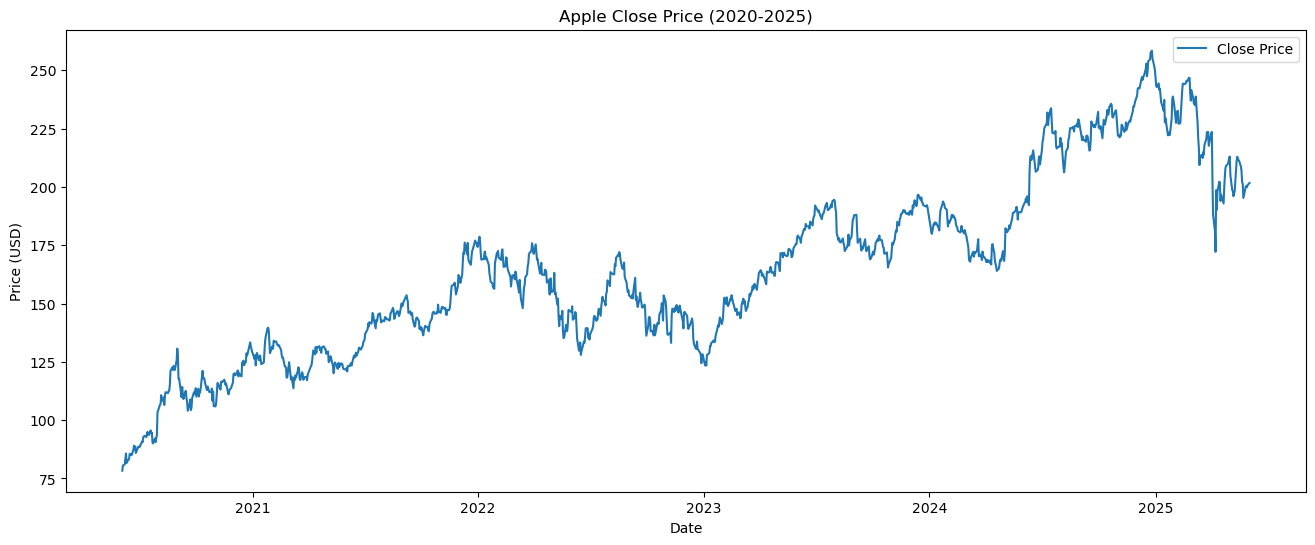

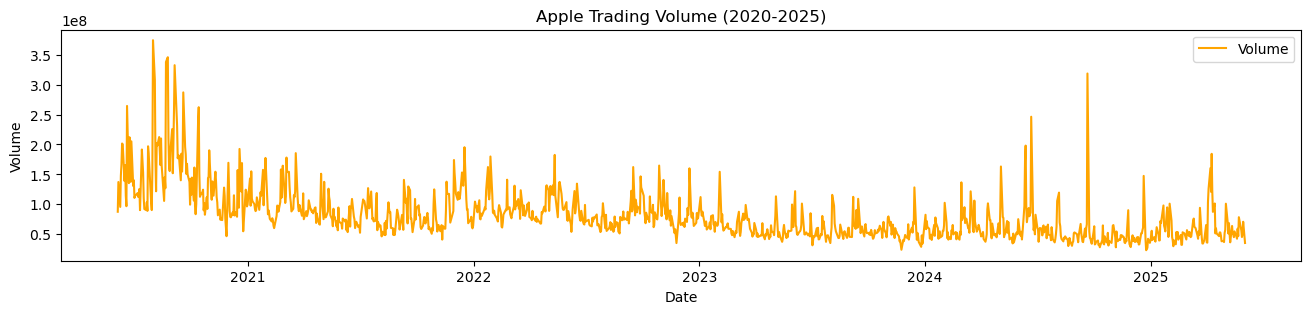

In [5]:
plt.figure(figsize=(16,6))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.title('Apple Close Price (2020-2025)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

plt.figure(figsize=(16,3))
plt.plot(df['Date'], df['Volume'], color='orange', label='Volume')
plt.title('Apple Trading Volume (2020-2025)')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

### Stastical Summary

In [6]:
df.describe()

,Date,Close,High,Low,Open,Volume
count,1255,1255.000000,1255.000000,1255.000000,1255.000000,1.255000e+03
mean,2022-11-30 12:32:42.071713280,164.321062,166.006163,162.443943,164.160646,8.078038e+07
min,2020-06-04 00:00:00,78.329315,79.131269,77.955067,78.579630,2.323470e+07
25%,2021-08-31 12:00:00,136.922234,139.392588,134.935222,136.720468,5.239195e+07
50%,2022-11-29 00:00:00,162.264175,163.728834,160.141728,161.654384,7.046270e+07
75%,2024-02-29 12:00:00,188.222137,189.675969,186.846649,188.102500,9.563880e+07
max,2025-06-02 00:00:00,258.396667,259.474086,257.010028,257.568678,3.743368e+08
std,NaN,38.179689,38.364282,37.891117,38.094942,4.191317e+07


## Rolling Mean & Volatility
- Calculate 30-day rolling mean and standard deviation to observe trends and volatility

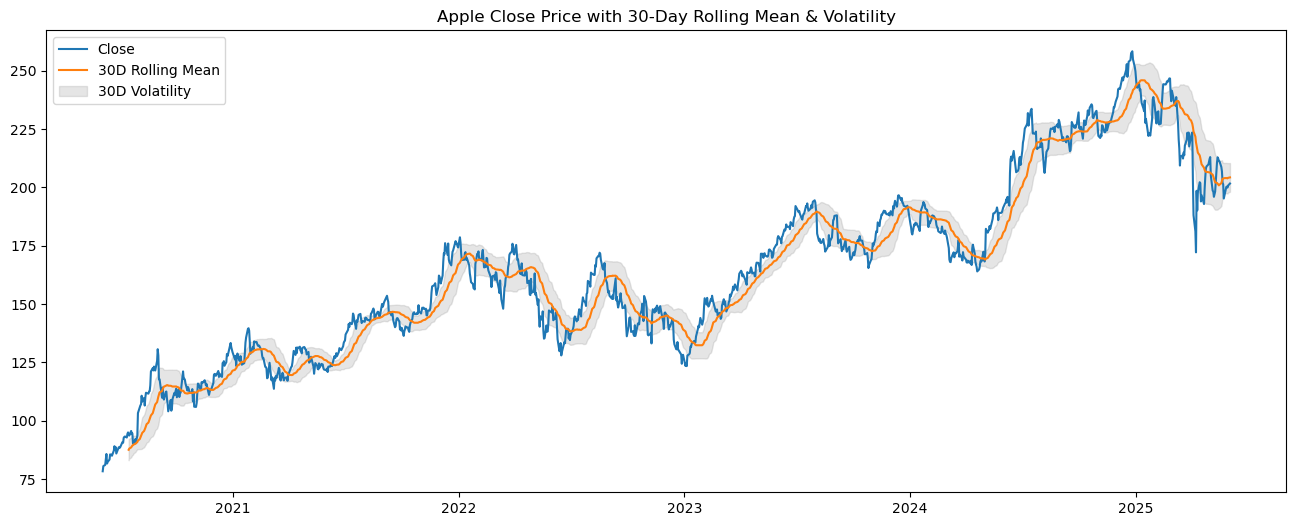

In [7]:
df['RollingMean_30'] = df['Close'].rolling(window=30).mean()
df['RollingStd_30'] = df['Close'].rolling(window=30).std()
plt.figure(figsize=(16,6))
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['RollingMean_30'], label='30D Rolling Mean')
plt.fill_between(df['Date'], df['RollingMean_30'] - df['RollingStd_30'], df['RollingMean_30'] + df['RollingStd_30'], color='gray', alpha=0.2, label='30D Volatility')
plt.legend()
plt.title('Apple Close Price with 30-Day Rolling Mean & Volatility')
plt.show()

## Moving Average Crossover Strategy Visualization
- Visualizing short-term vs. long-term moving averages to spot trend changes.

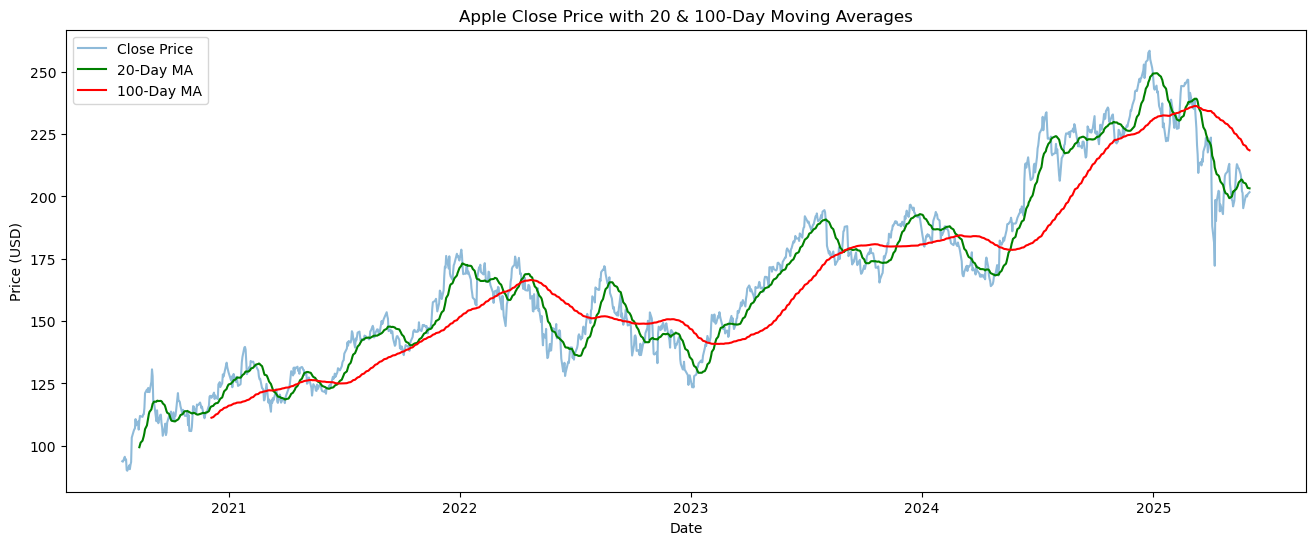

In [19]:
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA100'] = df['Close'].rolling(window=100).mean()

plt.figure(figsize=(16,6))
plt.plot(df['Date'], df['Close'], label='Close Price', alpha=0.5)
plt.plot(df['Date'], df['MA20'], label='20-Day MA', color='green')
plt.plot(df['Date'], df['MA100'], label='100-Day MA', color='red')
plt.title('Apple Close Price with 20 & 100-Day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

## Volatility (Rolling Standard Deviation) Chart
 periods of high and low volatility.

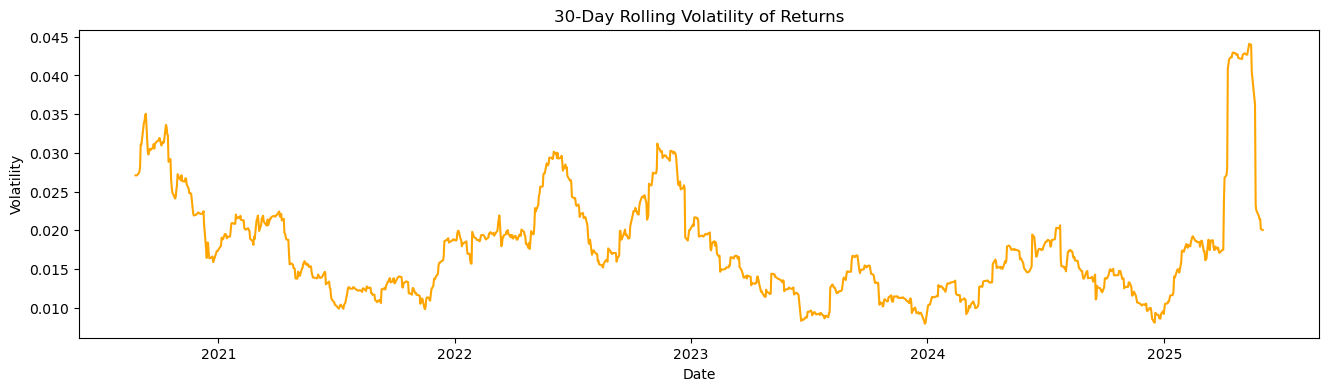

In [20]:
df['Volatility_30'] = df['Return'].rolling(window=30).std()

plt.figure(figsize=(16,4))
plt.plot(df['Date'], df['Volatility_30'], color='orange')
plt.title('30-Day Rolling Volatility of Returns')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()

## Drawdown Chart
- Visualizing the largest drops from previous peaks (risk metric).

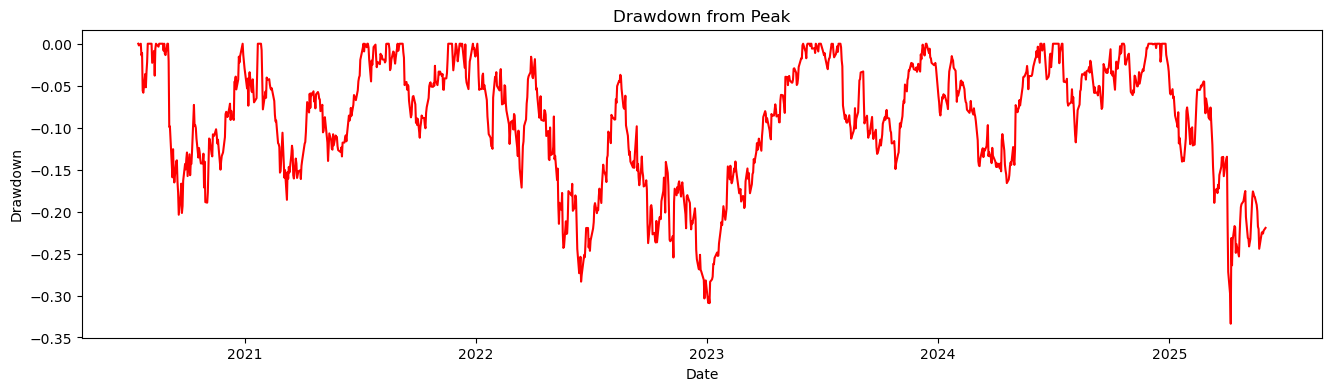

In [17]:
df['Cumulative_Max'] = df['Close'].cummax()
df['Drawdown'] = (df['Close'] - df['Cumulative_Max']) / df['Cumulative_Max']

plt.figure(figsize=(16,4))
plt.plot(df['Date'], df['Drawdown'], color='red')
plt.title('Drawdown from Peak')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.show()

## Monthly Average Close Price
- lets See how the average price changes month-to-month.

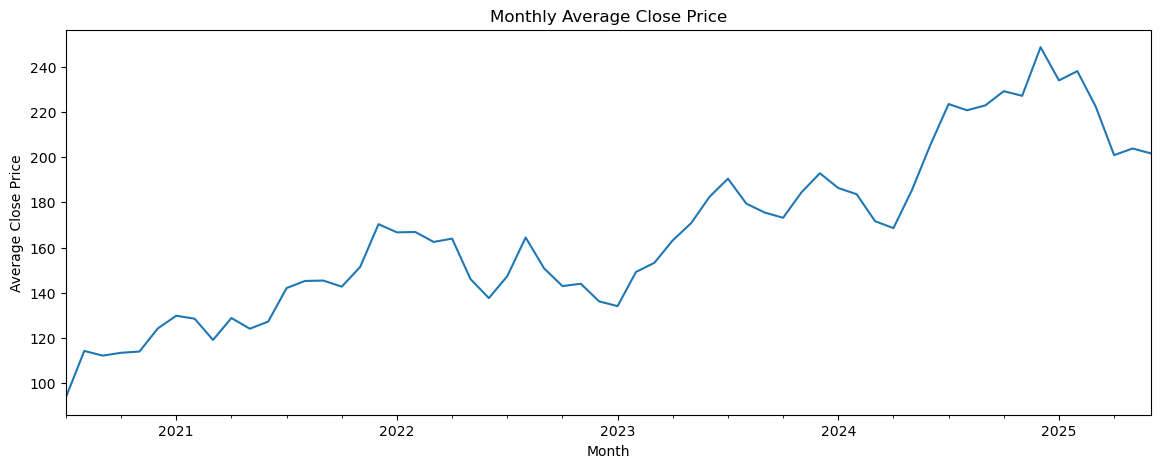

In [18]:
df['Month'] = df['Date'].dt.to_period('M')
monthly_avg = df.groupby('Month')['Close'].mean()

plt.figure(figsize=(14,5))
monthly_avg.plot()
plt.title('Monthly Average Close Price')
plt.xlabel('Month')
plt.ylabel('Average Close Price')
plt.show()

##  Feature Engineering 
- Daily returns
- High-Low spread
- Open-Close spread


In [8]:
df['Return'] = df['Close'].pct_change()
df['High_Low_Spread'] = df['High'] - df['Low']
df['Open_Close_Spread'] = df['Open'] - df['Close']
df = df.dropna()

## Seasonality & Trend Decomposition
We decompose the closing price into trend, seasonality, and residuals to better understand underlying patterns.

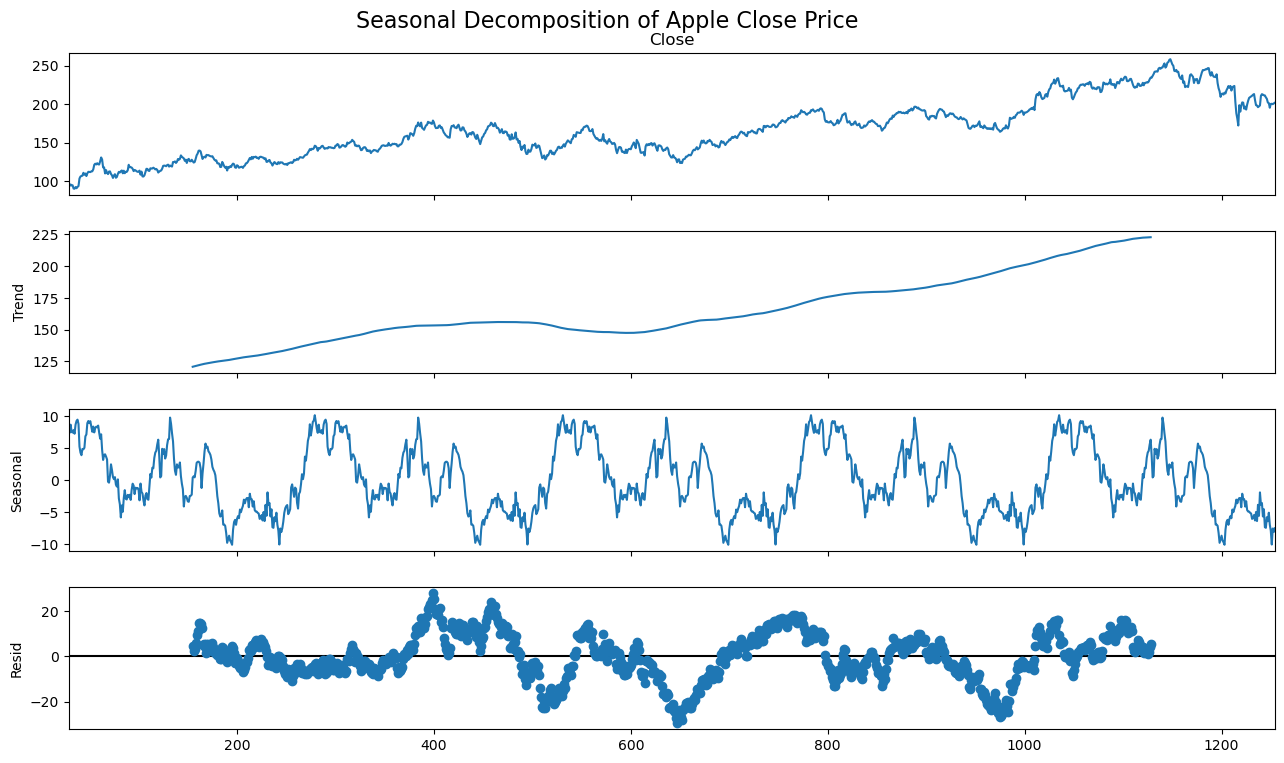

In [9]:
result = seasonal_decompose(df['Close'], model='additive', period=252)  # 252 trading days ≈ 1 year
fig = result.plot()
fig.set_size_inches(14, 8)
plt.suptitle('Seasonal Decomposition of Apple Close Price', fontsize=16)
plt.show()

- reveals both long-term trends and repeating seasonal effects in Apple’s stock price.

## Returns Distribution
We visualize the distribution of daily returns to assess risk and skewness.

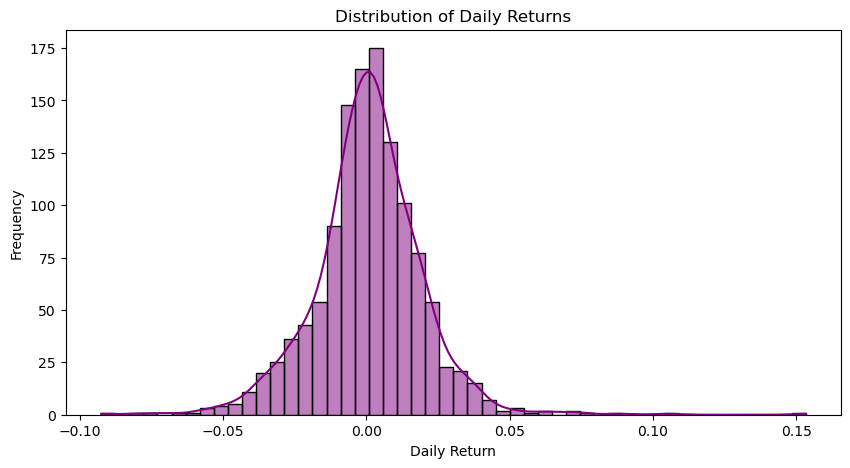

In [10]:
plt.figure(figsize=(10,5))
sns.histplot(df['Return'], bins=50, kde=True, color='purple')
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

- the majority of daily returns are close to zero, with occasional large moves (fat tails).

## Autocorrelation Analysis
We check for time dependencies in the closing price and returns.

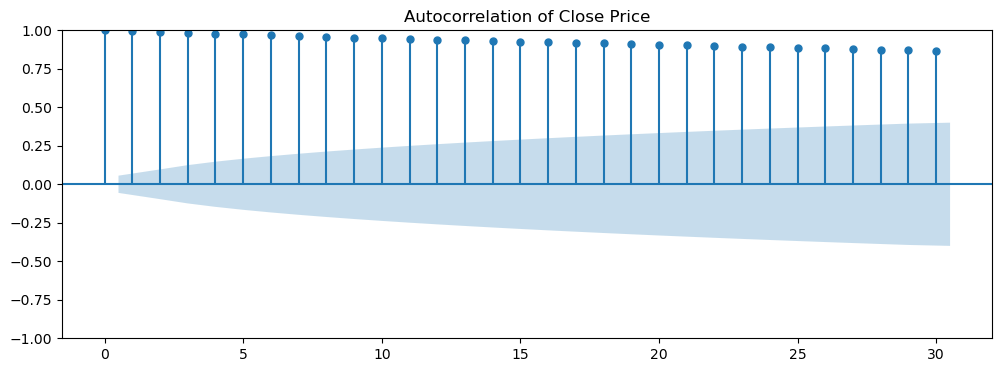

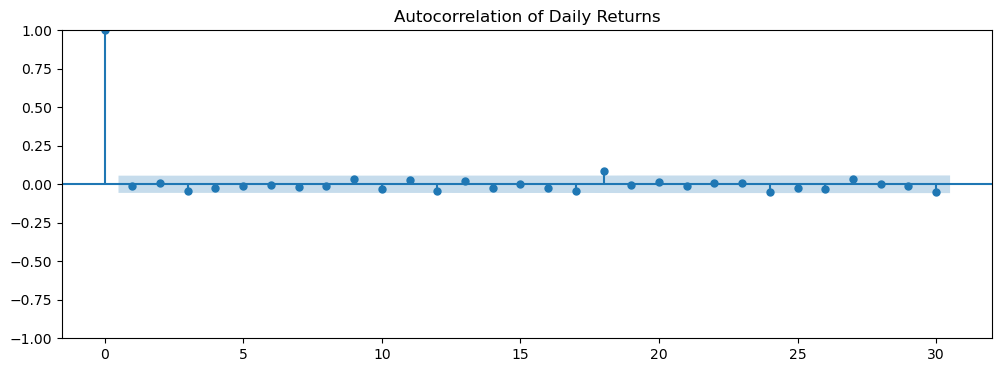

In [11]:
plt.figure(figsize=(12,4))
plot_acf(df['Close'], lags=30, ax=plt.gca())
plt.title('Autocorrelation of Close Price')
plt.show()

plt.figure(figsize=(12,4))
plot_acf(df['Return'].dropna(), lags=30, ax=plt.gca())
plt.title('Autocorrelation of Daily Returns')
plt.show()

- help identify if past prices or returns influence future values, guiding model selection.

## Correlation Analysis 

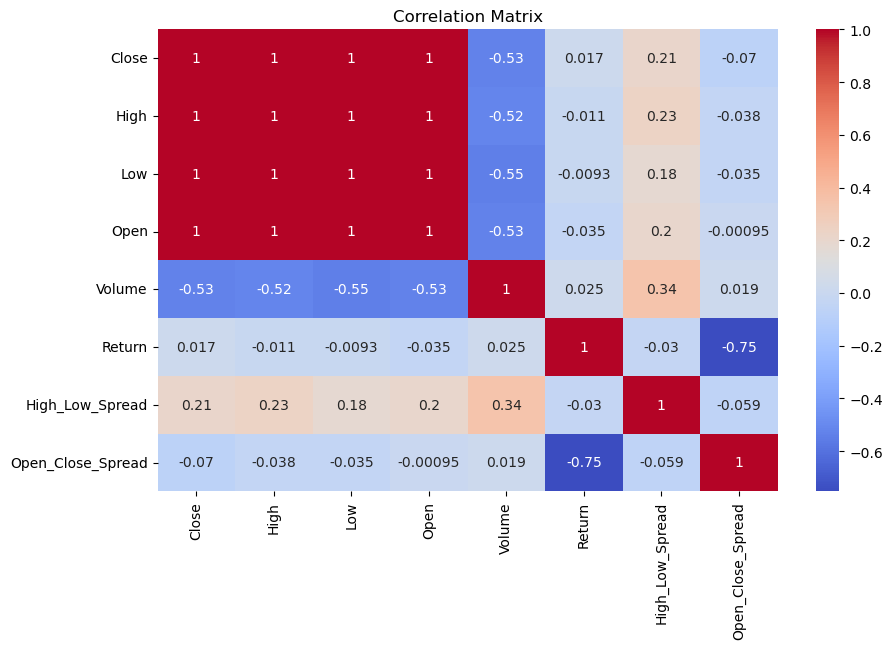

In [13]:
plt.figure(figsize=(10,6))
sns.heatmap(df[['Close','High','Low','Open','Volume','Return','High_Low_Spread','Open_Close_Spread']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Train-Test Split 
- last 180 days as test set for model evaluation

In [14]:
test_size = 180
train = df[:-test_size]
test = df[-test_size:]
print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (1046, 11), Test shape: (180, 11)


## ARIMA Forecasting
- ARIMA model as a baseline for time series forecasting


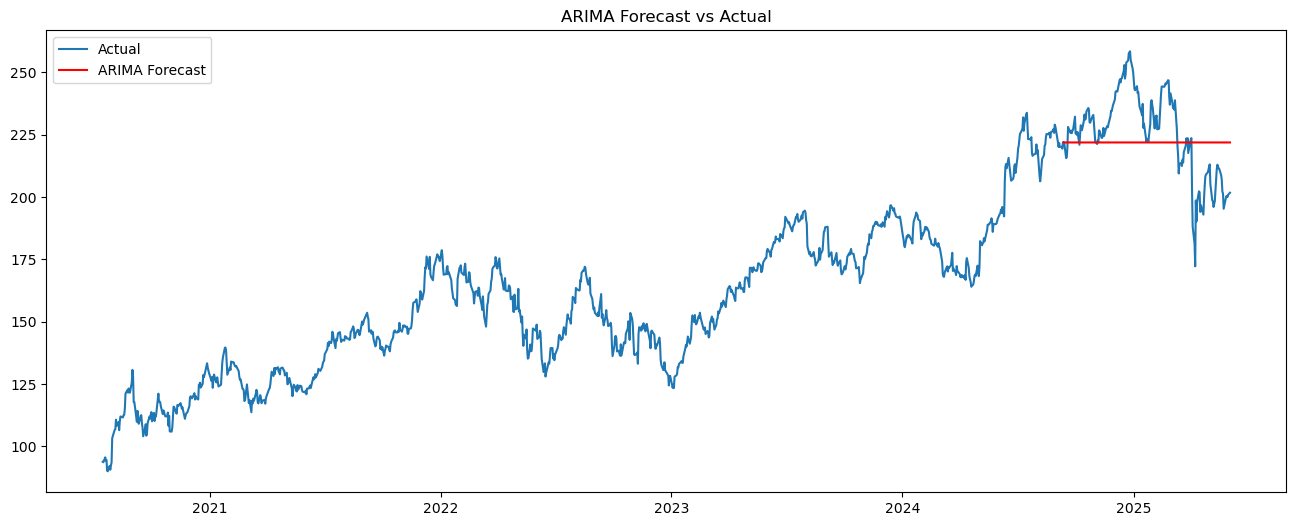

ARIMA MAE: 13.619307647354239


In [15]:
arima_model = ARIMA(train['Close'], order=(5,1,0))
arima_result = arima_model.fit()
arima_pred = arima_result.forecast(steps=test_size)
plt.figure(figsize=(16,6))
plt.plot(df['Date'], df['Close'], label='Actual')
plt.plot(test['Date'], arima_pred, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast vs Actual')
plt.legend()
plt.show()
print('ARIMA MAE:', mean_absolute_error(test['Close'], arima_pred))

## LSTM Forecasting 
- an LSTM neural network for improved forecasting
- a simple LSTM model for time series prediction.

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


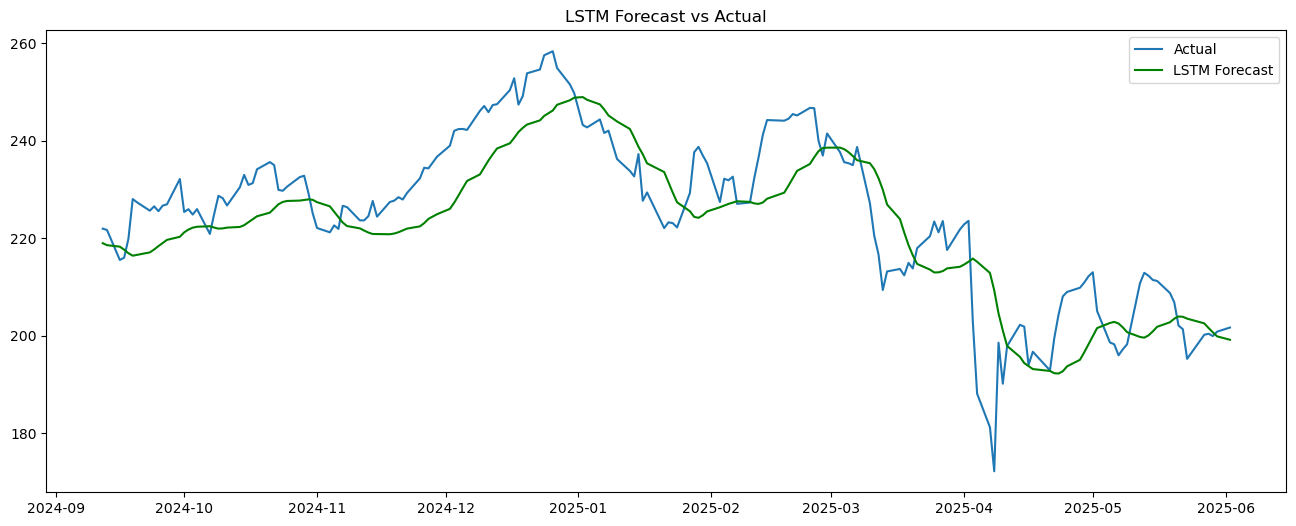

LSTM MAE: 7.591016387939451


In [16]:
# Preparing data
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df[['Close']])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(scaled_close, seq_length)
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# Building LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Predicting
lstm_pred = model.predict(X_test)
lstm_pred_inv = scaler.inverse_transform(lstm_pred)
y_test_inv = scaler.inverse_transform(y_test)

plt.figure(figsize=(16,6))
plt.plot(test['Date'].values, y_test_inv, label='Actual')
plt.plot(test['Date'].values, lstm_pred_inv, label='LSTM Forecast', color='green')
plt.title('LSTM Forecast vs Actual')
plt.legend()
plt.show()
print('LSTM MAE:', mean_absolute_error(y_test_inv, lstm_pred_inv))

## Insights
- **Apple's stock price** grew strongly from 2020 to 2025, with periods of volatility.
- **Trading volume** spiked during major events, often before large price moves.
- **Rolling mean and volatility** highlighted both stable and turbulent periods.
- **ARIMA** provided a baseline forecast but struggled with sudden changes.
- **LSTM** captured complex patterns and outperformed ARIMA in recent periods.
- **2025 surge:** Recent months saw a dramatic price increase, possibly due to new products or market optimism.
